# Notebook 1 - Read, Smooth, and Condition a DEM

This first jupyter notebook uses a polygon area of interest to read in a DEM from the USGS API, smooth the DEM using a bespoke smoothing method in the 'WhiteboxTools' python package, and conditions the DEM by breaching depressions also using WhiteboxTools.

NOTE: these conditioning steps are conducted in a separate notebook as the python packages required for the microwatershed delineation are incompatible with WhiteboxTools, which is needed for the conditioning.

Note: ensure to install the necessary python packages included in the venv39_dem.txt file.
A virtual environment with python version 3.9.13 must be used to ensure the package dependencies align.

In [ ]:
# Import packages
import os
import leafmap # pip install leafmap[raster]
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Initialize a map for plotting

m = leafmap.Map(center=[27.5, -80.3], zoom=12, height="600px")
# m

# Step 1 - Read DEM

In [ ]:
# Read in a polygon - this will serve as the area of interest that will get smoothed/conditioned

# Waterway village area for testing (smaller area)
wwv = gpd.read_file(r'data-inputs\\IRL-Boundary\\WaterwayVillage-Boundary.shp')
# Full IRL region
irl = gpd.read_file(r'data-inputs\\IRL-Boundary\\IRL-AOI_4326.shp')

# Read in DEM for area of interest from USGS API
leafmap.get_3dep_dem(
    wwv, # specifyAOI polygon
    resolution=10, # specify a resolution in meters. 10m is the default value for the microwatershed delineation
    output="wwv-10m.tif", # specify file name 
    dst_crs="EPSG:4326", # specify coordinate reference system - must be 4326 for the microwatershed delineation
    to_cog=True
)

In [12]:
# Define a function for plotting
def plot_dem(dem_path):
    # Open the DEM file
    with rasterio.open(dem_path) as src:
        dem = src.read(1)  # Read the first band
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Get spatial extent

    # Mask no-data values
    dem = np.where(dem == src.nodata, np.nan, dem)

    # Plot the DEM
    plt.figure(figsize=(8, 6))
    plt.imshow(dem, cmap="terrain", extent=extent, origin="upper")
    plt.colorbar(label="Elevation (m)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Digital Elevation Model (DEM)")
    plt.show()

In [ ]:
# Set DEM path
file = 'wwv-10m'
dem_path = fr'C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\\DEM\\{file}.tif'

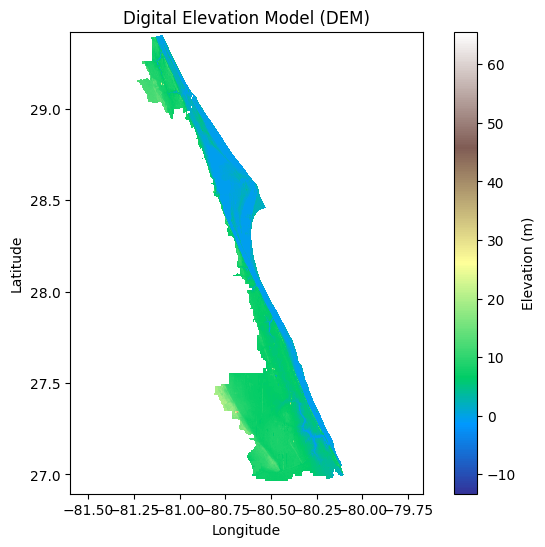

In [ ]:
# Plot the DEM
plot_dem(dem_path)

In [106]:
metadata = leafmap.image_metadata(dem_path)
metadata

{'bounds': {'left': -80.569805,
  'bottom': 27.585716,
  'right': -80.337849,
  'top': 27.781504},
 'crs': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]',
 'band_metadata': [('b1', {})],
 'band_descriptions': [('b1', 'elevation')],
 'dtype': 'float32',
 'nodata_type': 'Nodata',
 'colorinterp': ['gray'],
 'scales': [1.0],
 'offsets': [0.0],
 'colormap': None,
 'driver': 'GTiff',
 'count': 1,
 'width': 2546,
 'height': 2149,
 'overviews': [2, 4, 8],
 'nodata_value': nan,
 'nodata': nan,
 'transform': [9.110627255764973e-05,
  0.0,
  -80.56980540745118,
  0.0,
  -9.110627255764904e-05,
  27.781503547324103,
  0.0,
  0.0,
  1.0]}

# Step 2 - Smooth DEM

In [ ]:
# Initialize WhiteboxTools and set file paths for processing

wbt = leafmap.WhiteboxTools()
leaf_path = r'C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap'
data_path = fr'data-inputs\leafmap'
wbt.set_working_dir(r'C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap')
print(wbt.get_working_dir())

In [ ]:
# smooth the DEM with the WhiteboxTools "feature preserving smooting" method

output_path = fr"C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap\{file}_smoothed.tif"
wbt.feature_preserving_smoothing(
    dem_path, 
    output_path, 
    filter=3 # A filter size of 3 is commonly used
)

.\whitebox_tools.exe --run="FeaturePreservingSmoothing" --wd="C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\\DEM\\IRL-full-region.tif' --output='C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap\IRL-full-region_smoothed.tif' --filter=3 --norm_diff=15.0 --num_iter=3 --max_diff=0.5 -v --compress_rasters=False

*****************************************
* Welcome to FeaturePreservingSmoothing *
* Powered by WhiteboxTools              *
* www.whiteboxgeo.com                   *
*****************************************
Reading data...
It appears that the DEM is in geographic coordinates. The z-factor has been updated to 0.0000089851765.
Calculating normal vectors: 0%
Calculating normal vectors: 1%
Calculating normal vectors: 2%
Calculating normal vectors: 3%
Calculating normal vectors: 4%
Calculating norm

0

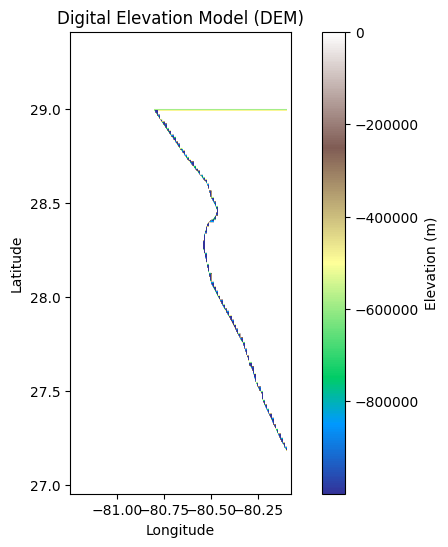

In [13]:
plot_dem(f"{leaf_path}\{file}_smoothed.tif")

In [ ]:
# Find no flow cells after the smoothing
wbt.find_no_flow_cells(f'{file}_smoothed.tif', f"{file}_noflow.tif")

.\whitebox_tools.exe --run="FindNoFlowCells" --wd="C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='IRL-full-region_smoothed.tif' --output='IRL-full-region_noflow.tif' -v --compress_rasters=False

******************************
* Welcome to FindNoFlowCells *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress: 42%
Pr

0

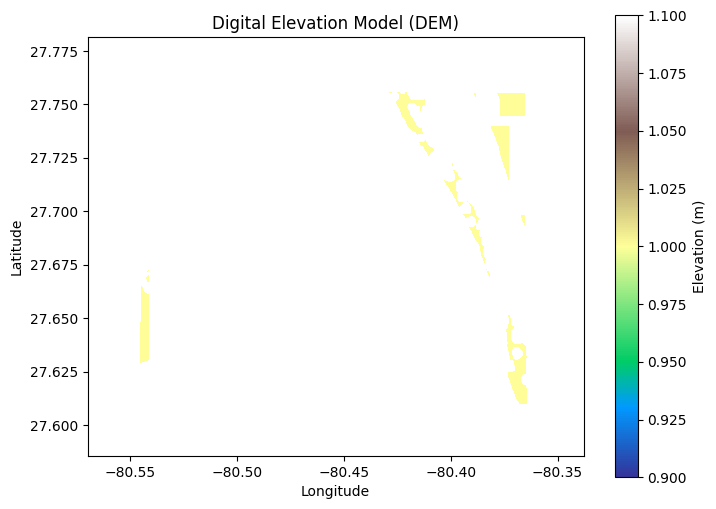

In [ ]:
# Ensure there are no major issues with the no flow output by checking the metadata
plot_dem(fr"{leaf_path}\{file}_noflow.tif")

# Step 3 - Breach Depressions

In [ ]:
# breach depressions on the smoothed DEM
wbt.breach_depressions(f'{file}_smoothed.tif', f"{file}_breached.tif")

.\whitebox_tools.exe --run="BreachDepressions" --wd="C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='IRL-full-region_smoothed.tif' --output='IRL-full-region_breached.tif' -v --compress_rasters=False

********************************
* Welcome to BreachDepressions *
* Powered by WhiteboxTools     *
* www.whiteboxgeo.com          *
********************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%


0

In [ ]:
# Find no flow cells 
wbt.find_no_flow_cells(f"{file}_breached.tif", f"{file}_noflow2.tif")

.\whitebox_tools.exe --run="FindNoFlowCells" --wd="C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='irl-full-region_10m_breached.tif' --output='irl-full-region_10m_noflow2.tif' -v --compress_rasters=False

******************************
* Welcome to FindNoFlowCells *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
thread 'main' panicked at whitebox-raster\src\geotiff\ifd.rs:115:23:
Error converting TAG(34737) to ASCII (value=[176, 95, 84, 28, 1, 0, 0, 0]) invalid utf-8 sequence of 1 bytes from index 0
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


0

# Pre-processing complete

The resulting breached output should be used as the INPUT into the second notebook to delineate the microwatersheds

### Optional - sanity check flow direction, flow acc, and stream network output

In [16]:
wbt.d8_pointer(f"{file}_breached.tif", f"{file}_flow_direction.tif")

.\whitebox_tools.exe --run="D8Pointer" --wd="C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --dem='IRL-full-region_breached.tif' --output='IRL-full-region_flow_direction.tif' -v --compress_rasters=False

****************************
* Welcome to D8Pointer     *
* Powered by WhiteboxTools *
* www.whiteboxgeo.com      *
****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40%
Progress: 41%
Progress

0

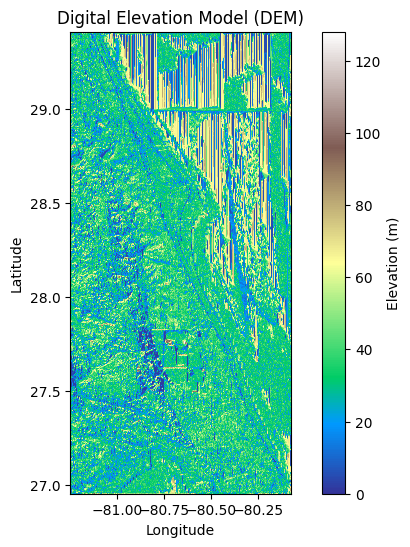

In [17]:
plot_dem(fr"{leaf_path}\{file}_flow_direction.tif")

In [188]:
wbt.d8_flow_accumulation(f"{file}_breached.tif", f"{file}_flow_accum.tif")

.\whitebox_tools.exe --run="D8FlowAccumulation" --wd="C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --input='irl-full-region_10m_breached.tif' --output='irl-full-region_10m_flow_accum.tif' --out_type=cells -v --compress_rasters=False

*********************************
* Welcome to D8FlowAccumulation *
* Powered by WhiteboxTools      *
* www.whiteboxgeo.com           *
*********************************
Reading data...
thread 'main' panicked at whitebox-raster\src\geotiff\ifd.rs:115:23:
Error converting TAG(34737) to ASCII (value=[176, 95, 84, 28, 1, 0, 0, 0]) invalid utf-8 sequence of 1 bytes from index 0
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


0

In [161]:
m.add_raster(fr"data-inputs\leafmap\{file}_flow_accum.tif", layer_name="Flow Accumulation")
# m

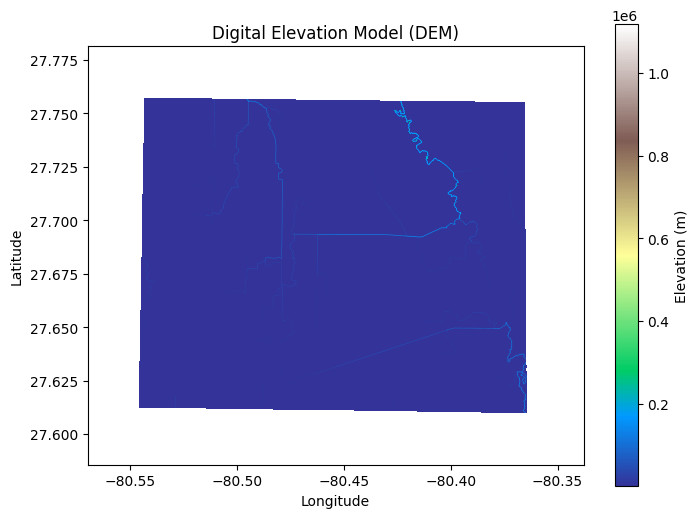

In [162]:
plot_dem(fr"{leaf_path}\{file}_flow_accum.tif")

In [163]:
wbt.extract_streams(f"{file}_flow_accum.tif", f"{file}_streams.tif", threshold=750)

.\whitebox_tools.exe --run="ExtractStreams" --wd="C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --flow_accum='wwv-test_10m_flow_accum.tif' --output='wwv-test_10m_streams.tif' --threshold='750' -v --compress_rasters=False

*****************************
* Welcome to ExtractStreams *
* Powered by WhiteboxTools  *
* www.whiteboxgeo.com       *
*****************************
Reading data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Progress: 34%
Progress: 35%
Progress: 36%
Progress: 37%
Progress: 38%
Progress: 39%
Progress: 40

0

In [164]:
wbt.raster_streams_to_vector(
    f"{file}_streams.tif", d8_pntr=f"{file}_flow_direction.tif", output=f"{file}_streams.shp"
)

.\whitebox_tools.exe --run="RasterStreamsToVector" --wd="C:\Users\alden.summerville\Documents\dev-local\IRL-MIA-development\jupyter\data-inputs\leafmap" --streams='wwv-test_10m_streams.tif' --d8_pntr='wwv-test_10m_flow_direction.tif' --output='wwv-test_10m_streams.shp' -v --compress_rasters=False

************************************
* Welcome to RasterStreamsToVector *
* Powered by WhiteboxTools         *
* www.whiteboxgeo.com              *
************************************
Reading pointer data...
Reading streams data...
Progress: 0%
Progress: 1%
Progress: 2%
Progress: 3%
Progress: 4%
Progress: 5%
Progress: 6%
Progress: 7%
Progress: 8%
Progress: 9%
Progress: 10%
Progress: 11%
Progress: 12%
Progress: 13%
Progress: 14%
Progress: 15%
Progress: 16%
Progress: 17%
Progress: 18%
Progress: 19%
Progress: 20%
Progress: 21%
Progress: 22%
Progress: 23%
Progress: 24%
Progress: 25%
Progress: 26%
Progress: 27%
Progress: 28%
Progress: 29%
Progress: 30%
Progress: 31%
Progress: 32%
Progress: 33%
Pr

0

In [165]:
leafmap.vector_set_crs(source=fr"data-inputs\leafmap\{file}_streams.shp", output=f"{data_path}\{file}_streams.shp", crs="EPSG:4326")

In [166]:
m.add_shp(
    f"{data_path}\{file}_streams.shp", layer_name="Streams Vector", style={"color": "#ff0000", "weight": 3}
)
m

Map(center=[27.68361, -80.453827], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…